# IMU Calibration

Notebook to read data from IMU

ref: https://github.com/adafruit/Adafruit_SensorLab/blob/master/notebooks/Mag_Gyro_Calibration.ipynb

ref: https://github.com/adafruit/Adafruit_Learning_System_Guides/blob/main/Jupyter_USB/LSM6DSOX_Accel.ipynb

In [16]:

import time
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import datetime
import matplotlib.dates as mdates
from collections import deque
import numpy as np

import serial
import re

PORT = "/dev/cu.usbmodem14101"

# How many sensor samples we want to store
HISTORY_SIZE = 2500

# Pause re-sampling the sensor and drawing for INTERVAL seconds
INTERVAL = 0.01

In [17]:
serialport = None

def get_imu_data():
    global serialport
    if not serialport:
        # open serial port
        serialport = serial.Serial(PORT, 9600, timeout=0.1)
        # check which port was really used
        print("Opened", serialport.name)
        # Flush input
        time.sleep(3)
        serialport.readline()

    # Poll the serial port
    line = str(serialport.readline(), 'utf-8')
    if not line:
        return None
    #print(line)

    # following code needs to be adapted to the output string coming from Arduino
    vals = line.replace("\t", " ").split(" ")[0:3] # remove '\r\n'
    #print(vals)
    
    try:
        vals = [float(i) for i in vals]
    except ValueError:
        return None
    #print(vals)
    return vals

for _ in range(20):
    print(get_imu_data())

Opened /dev/cu.usbmodem14101
[0.73, -0.37, -0.12]
[0.92, -0.24, -0.18]
[0.67, -0.31, -0.24]
[0.67, -0.31, -0.24]
[0.67, -0.37, -0.12]
[0.67, -0.37, -0.12]
[0.61, -0.37, -0.06]
[0.61, -0.37, -0.06]
[0.79, -0.43, -0.12]
[0.79, -0.43, -0.12]
[0.67, -0.37, -0.12]
[0.67, -0.37, -0.12]
[0.61, -0.43, -0.12]
[0.73, -0.37, -0.06]
[0.73, -0.37, -0.06]
[0.79, -0.24, -0.31]
[0.79, -0.24, -0.31]
[0.73, -0.43, -0.24]
[0.73, -0.43, -0.24]
[0.61, -0.31, -0.06]


## Plot data to calibrate the Gyroscope

Pay attention to the units
Used two points calibration method

Put down the board and do not touch or move it!
3...2...1...COLLECTING GYRO DATA
Opened /dev/cu.usbmodem14101
Final calibration in dps: [0.705, -0.335, -0.125]

------
Samples: 250


<IPython.core.display.Javascript object>


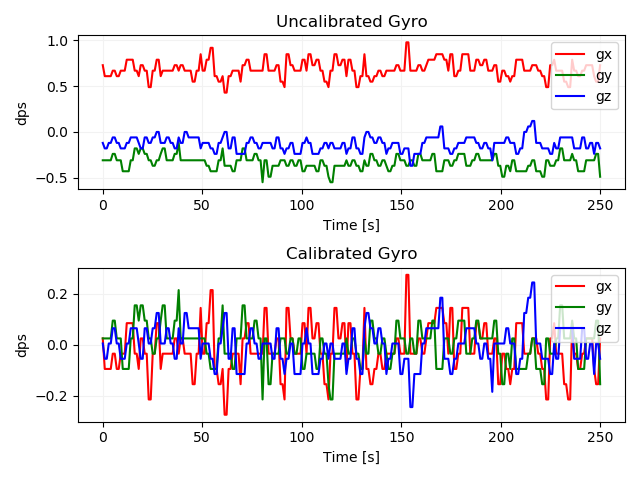

In [23]:
print("Put down the board and do not touch or move it!")
for s in range(3, 0, -1):
    print(s, end='...')
    time.sleep(1)
print("COLLECTING GYRO DATA")

# close port in case its open
if serialport:
    try:
        serialport.close()
    except NameError:
        pass

serialport = None

# Deque for axes
gyro_x = deque(maxlen=HISTORY_SIZE//10)
gyro_y = deque(maxlen=HISTORY_SIZE//10)
gyro_z = deque(maxlen=HISTORY_SIZE//10)

while len(gyro_x) < (HISTORY_SIZE//10):
    ret = get_imu_data()
    #print(ret)
    if not ret:
        continue
    x, y, z = ret[0:3]
    gyro_x.append(x)
    gyro_y.append(y)
    gyro_z.append(z)
    

# TODO: remove popleft()
for _ in range(3):
    gyro_x.popleft()
    gyro_y.popleft()
    gyro_z.popleft()


    
min_x = min(gyro_x)
max_x = max(gyro_x)
min_y = min(gyro_y)
max_y = max(gyro_y)
min_z = min(gyro_z)
max_z = max(gyro_z)


print("Gyro X range: ", min_x, max_x)
print("Gyro Y range: ", min_y, max_y)
print("Gyro Z range: ", min_z, max_z)


gyro_calibration = [ (max_x + min_x) / 2, (max_y + min_y) / 2, (max_z + min_z) / 2]
print("Final calibration in dps:", gyro_calibration)


fig, (uncal, cal) = plt.subplots(2, 1)

# Clear all axis
uncal.cla()
t = np.linspace(0, len(gyro_x), len(gyro_x))
# plot uncalibrated data
uncal.plot(t, gyro_x, color='r', label = 'gx')
uncal.plot(t, gyro_y, color='g', label = 'gy')
uncal.plot(t, gyro_z, color='b', label = 'gz')
uncal.title.set_text("Uncalibrated Gyro")
uncal.set(ylabel='dps', xlabel='Time [s]')
uncal.grid(color='0.95')
uncal.legend(loc='upper right')
# plot calibrated data
cal.plot(t, [x - gyro_calibration[0] for x in gyro_x], color='r', label = 'gx')
cal.plot(t, [y - gyro_calibration[1] for y in gyro_y], color='g', label = 'gy')
cal.plot(t, [z - gyro_calibration[2] for z in gyro_z], color='b', label = 'gz')
cal.title.set_text("Calibrated Gyro")
cal.set(ylabel='dps', xlabel = 'Time [s]')
cal.grid(color='0.95')
cal.legend(loc='upper right')

fig.tight_layout()
fig.show()
serialport.close()

## Plot realtime data

It is not running in real time. Serial plot from Arduino must faster.

ref: https://towardsdatascience.com/matplotlib-animations-in-jupyter-notebook-4422e4f0e389

<IPython.core.display.Javascript object>


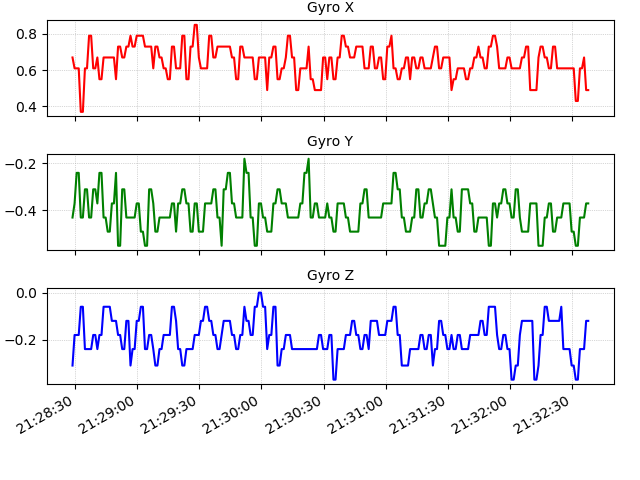

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import datetime
import matplotlib.dates as mdates
from collections import deque

# close port in case its open
if serialport:
    try:
        serialport.close()
    except NameError:
        pass

serialport = None


# How many sensor samples we want to store
HISTORY_SIZE = 250

# Pause re-sampling the sensor and drawing for INTERVAL seconds
INTERVAL = 0.000001

# Deque for X-Axis (time)
x_vals = deque(maxlen=HISTORY_SIZE)

# Deque for Y-Axis (gyroscope readings)
gyro_x = deque(maxlen=HISTORY_SIZE)
gyro_y = deque(maxlen=HISTORY_SIZE)
gyro_z = deque(maxlen=HISTORY_SIZE)

# Create 3 side-by-side subplots
fig, (ax1, ax2, ax3) = plt.subplots(3,1)

# Automatically adjust subplot parameters for nicer padding between plots
plt.tight_layout()

def animate(i):
    # Pull data from IMU
    gyro_data = get_imu_data()
    # Add the X/Y/Z values to the accel arrays
    gyro_x.append(gyro_data[0])
    gyro_y.append(gyro_data[1])
    gyro_z.append(gyro_data[2])
    
    # Grab the datetime, auto-range based on length of accel_x array
    x_vals = [datetime.datetime.now() + datetime.timedelta(seconds=i) for i in range(len(gyro_x))]
    
    # Clear all axis
    ax1.cla()
    ax2.cla()
    ax3.cla()

    # Set grid titles
    ax1.set_title('Gyro X', fontsize=10)
    ax2.set_title('Gyro Y', fontsize=10)
    ax3.set_title('Gyro Z', fontsize=10)
   
    # Enable subplot grid lines
    ax1.grid(True, linewidth=0.5, linestyle=':')
    ax2.grid(True, linewidth=0.5, linestyle=':')   
    ax3.grid(True, linewidth=0.5, linestyle=':')

    # Rotate and align x-axis tick labels so they look better
    fig.autofmt_xdate()

    # Display the sub-plots
    ax1.plot(x_vals, gyro_x, color='r')
    ax2.plot(x_vals, gyro_y, color='g')
    ax3.plot(x_vals, gyro_z, color='b')
    
    # Pause the plot for INTERVAL seconds 
    #plt.pause(INTERVAL)

# Update graph every 125ms
ani = FuncAnimation(fig, animate)